Helper functions for plotting, data instantiation, and tensor reshaping are found [here]().

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [62]:
torch.manual_seed(6969)
n, c, h, w = 10, 2, 512, 512
shape = n, c, h, w

def colorize(feature_map):
    """color 2D tensor white data with random covariance matrix"""
    tmp = torch.randn((c, c))
    Sigma = tmp.T @ tmp
    chol = torch.cholesky(Sigma) * torch.rand(1) * 5
    colored_feature_map = chol @ feature_map
    return colored_feature_map

def flatten_space(feature_map):  # squash spatial dims
    return torch.flatten(feature_map, start_dim=-2).clone()  # n x c x (h*w)

def unflatten_space(feature_map, tensor_shape=shape):  # unsquash spatial dims
    return feature_map.reshape(tensor_shape).clone()  # n x c x h x w

def flatten_batch_and_space(feature_map):  # flatten both batch and space
    return feature_map.transpose(1,0).flatten(start_dim=1).clone()  # c x (n*h*w)

def unflatten_batch_and_space(feature_map, tensor_shape=(c,n,h,w)):  # undo flatten batch + space
    return feature_map.reshape(tensor_shape).transpose(1,0).clone()  # n x c x h x w

def feature_scatter(batched_feature_maps, nrows=2, ncols=5):
    """Helper for plotting all channels' responses"""
    fig, ax = plt.subplots(nrows, ncols, squeeze=False, sharex='all', sharey='all',
                           figsize=(8,4))
    batched_squashed_feature_maps = flatten_space(batched_feature_maps)
    for i in range(nrows*ncols):
        idx = np.unravel_index(i, (nrows, ncols))
        ax[idx].scatter(batched_squashed_feature_maps[i][0,:],
                        batched_squashed_feature_maps[i][1,:])
        ax[idx].set(title=f'n={i}')
    ax[0, 0].set(xlabel='channel 0', ylabel='channel 1')#, xticks=[], yticks=[])
    fig.tight_layout()
    return fig, ax

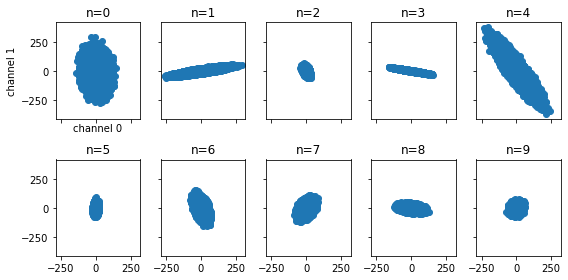

In [67]:
activations = torch.randn((n, c, h*w))
activations = torch.stack([colorize(a) for a in activations])
activations = unflatten_space(activations)
activations = unflatten_batch_and_space(colorize(flatten_batch_and_space(activations)))
feature_scatter(activations);

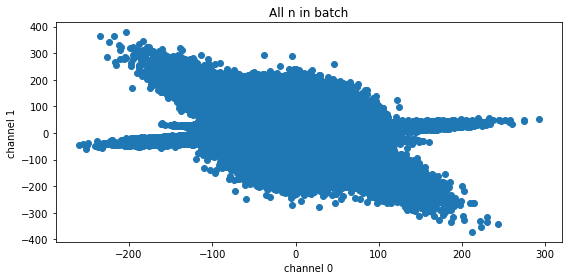

In [68]:
fig, ax = feature_scatter(flatten_batch_and_space(activations).view(1,c,n*h*w,1), nrows=1, ncols=1)
ax[0,0].set(title=f'All n in batch');

In [65]:
def batch_whiten(batch_feature_map):
    """whiten each feature using stats across all images in batch"""
    y = flatten_batch_and_space(batch_feature_map)
    N = y.shape[-1]
    cov = y @ y.T / (N - 1)
    u, lambduh, _ = torch.svd(cov)
    lambduh_inv_sqrt = torch.diag(lambduh**(-.5))
    zca_whitener = u @ lambduh_inv_sqrt @ u.T
    z = zca_whitener @ y
    return unflatten_batch_and_space(z)

def instance_whiten(batch_feature_map):
    """whiten each feature map within individual image in batch"""
    y = flatten_space(batch_feature_map)
    N = y.shape[-1]
    cov = torch.einsum('bcx, bdx -> bcd', y, y) / (N-1)  # compute covs along batch dim
    u, lambduh, _ = torch.svd(cov)
    lambduh_inv_sqrt = torch.diag_embed(lambduh**(-.5))
    zca_whitener = torch.einsum('nab, nbc, ncd -> nad', u, lambduh_inv_sqrt, u.transpose(-2,-1))
    z = torch.einsum('bac, bcx -> bax', zca_whitener, y)
    return unflatten_space(z)

- n in batch are sequential frames of a video
- assuming zero-mean
- after batch whitening: note how the axis limits are scaled down now
    - the chans among indiv n in the batch are clearly still correlated
- after instance whitening, they're all white

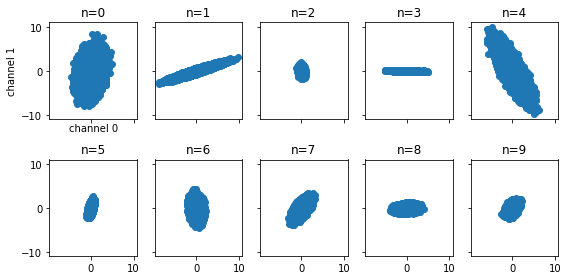

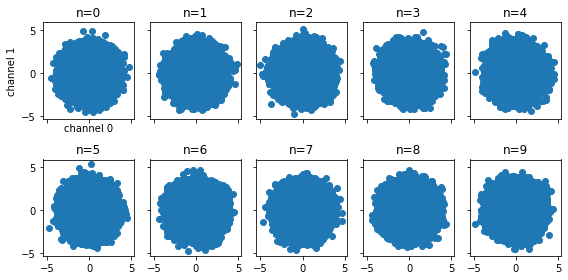

In [69]:
feature_scatter(batch_whiten(activations))

feature_scatter(instance_whiten(activations));

